In [21]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [85]:
dataset = pd.read_csv('../dataset/stroke-data.csv')

dataset.replace( {'No': 0, 'Yes': 1, 'Private': 0, 'Self-employed': 1, 'Govt_job': 2, 'children': 3, 'Never_worked': 4 }, inplace=True)
dataset.replace( {'Urban': 0, 'Rural': 1, 'formerly smoked': 1, 'never smoked': 2, 'smokes': 3, 'Unknown': 4 }, inplace=True)
#dataset.drop(['Race', 'GenHealth','Stroke','DiffWalking','PhysicalHealth','Asthma','MentalHealth','Diabetic','KidneyDisease','SkinCancer'], axis=1,inplace=True)

features_names = ['age','hypertension','heart_disease', 'ever_married','work_type','Residence_type', 'avg_glucose_level','bmi', 'smoking_status']
target_names = 'stroke_situation'

target = dataset[target_names]
feature = dataset[features_names]

print(target.shape)
print(feature.shape)


(5110,)
(5110, 9)


In [86]:
X_train, X_test, y_train, y_test = train_test_split(
    feature,target,
    test_size=0.2,
    random_state=np.random.randint(10))

In [94]:
batch_size = 32
X_train=np.asarray(X_train).astype(float)
y_train=np.asarray(y_train).astype(float)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(batch_size)

X_test=np.asarray(X_test).astype(float)
y_test=np.asarray(y_test).astype(float)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(batch_size)

In [104]:
from tensorflow import keras

inputs = keras.Input(shape=(9,))
h1 = keras.layers.Dense(10,activation=tf.nn.relu)(inputs)
h2 = keras.layers.Dense(10,activation=tf.nn.relu)(h1)
h3 = keras.layers.Dense(3,activation=tf.nn.relu)(h2)
outputs = keras.layers.Dense(2)(h3)
model = keras.Model(inputs=inputs, outputs=outputs, name="stroke_model")

model.summary()

Model: "stroke_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 20)]              0         
                                                                 
 dense_24 (Dense)            (None, 10)                210       
                                                                 
 dense_25 (Dense)            (None, 10)                110       
                                                                 
 dense_26 (Dense)            (None, 3)                 33        
                                                                 
 dense_27 (Dense)            (None, 3)                 12        
                                                                 
Total params: 365
Trainable params: 365
Non-trainable params: 0
_________________________________________________________________


In [89]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


In [98]:
next_batch_dataset = next(iter(train_dataset))
features,labels = next_batch_dataset
predictions = model(features)

print(f"Prediction: {tf.argmax(predictions, axis=1)}")
print(f"    Labels: {labels}")

ValueError: Input 0 of layer "stroke_model" is incompatible with the layer: expected shape=(None, 4), found shape=(32, 9)

In [99]:
def loss(model, x, y, training):
  y_ = model(x, training=training)

  return loss_object(y_true=y, y_pred=y_)

l = loss(model, features, labels, training=False)
print(f"Loss test: {l}")

ValueError: Input 0 of layer "stroke_model" is incompatible with the layer: expected shape=(None, 4), found shape=(32, 9)

In [100]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

In [101]:
loss_value, grads = grad(model, features, labels)

print(f"Step: {optimizer.iterations.numpy()}, Initial Loss: {loss_value.numpy()}")

optimizer.apply_gradients(zip(grads, model.trainable_variables))
print(f"Step: {optimizer.iterations.numpy()}, Loss: {loss(model, features, labels, training=True).numpy()}")



ValueError: Input 0 of layer "stroke_model" is incompatible with the layer: expected shape=(None, 4), found shape=(32, 9)

In [103]:
train_loss_results = []
train_accuracy_results = []

num_epochs = 5

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    for x, y in train_dataset:
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Track progress
        epoch_loss_avg.update_state(loss_value)  
        epoch_accuracy.update_state(y, model(x, training=True))

    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())


    print(f"Epoch {epoch:03d}: Loss: {epoch_loss_avg.result():.3f}, Accuracy: {epoch_accuracy.result():.3%}")

ValueError: Input 0 of layer "stroke_model" is incompatible with the layer: expected shape=(None, 4), found shape=(32, 9)

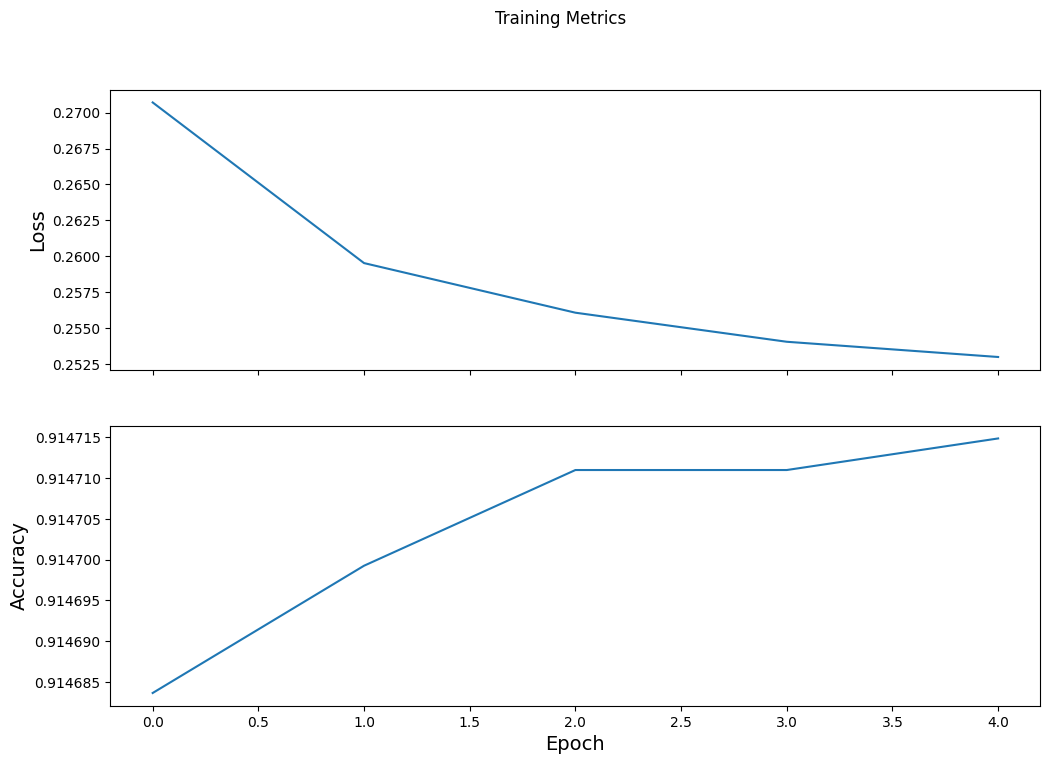

In [47]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

In [12]:
test_accuracy = tf.keras.metrics.Accuracy()

for (x, y) in test_dataset:
  logits = model(x, training=False)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print(f"Test set accuracy: {test_accuracy.result():.3%}")

NameError: name 'test_dataset' is not defined

In [49]:
model.save('./model',overwrite=True)

INFO:tensorflow:Assets written to: ./model\assets
